In [1]:
import os
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
from scipy.stats import pearsonr
import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
import matplotlib.pyplot as plt
load_dotenv()
os.chdir(os.path.expanduser(os.getenv('PROJECT_WORKING_DIRECTORY')))

train = pd.read_csv('data/stsbenchmark/train.csv')
test = pd.read_csv('data/stsbenchmark/test.csv')
dev = pd.read_csv('data/stsbenchmark/dev.csv')

data = {'train':train, 'test':test, 'dev':dev}
# normalise scores to 0-1
for df in data.values():
    df['score'] = df['score'] / 5.

all_data = pd.concat([train, test, dev])

In [2]:
df

,split,genre,dataset,year,sid,score,sentence1,sentence2
0,dev,main-captions,MSRvid,2012test,0,1.00,A man with a hard hat is dancing.,A man wearing a hard hat is dancing.
1,dev,main-captions,MSRvid,2012test,2,0.95,A young child is riding a horse.,A child is riding a horse.
2,dev,main-captions,MSRvid,2012test,3,1.00,A man is feeding a mouse to a snake.,The man is feeding a mouse to the snake.
3,dev,main-captions,MSRvid,2012test,7,0.48,A woman is playing the guitar.,A man is playing guitar.
4,dev,main-captions,MSRvid,2012test,8,0.55,A woman is playing the flute.,A man is playing a flute.
...,...,...,...,...,...,...,...,...
1495,dev,main-news,headlines,2016,1283,0.40,Scientists prove there is water on Mars,Has Nasa discovered water on Mars?
1496,dev,main-news,headlines,2016,1434,0.00,Pranab stresses need to strive for peace by na...,WTO: India regrets action of developed nations
1497,dev,main-news,headlines,2016,1440,0.40,Volkswagen skids into red in wake of pollution...,"Volkswagen's ""gesture of goodwill"" to diesel o..."
1498,dev,main-news,headlines,2016,1477,0.00,Obama is right: Africa deserves better leadership,Obama waiting for midterm to name attorney gen...


## sparse gp regression with pyro

In [5]:
lmodel = 'xlm-r-distilroberta-base-paraphrase-v1'
embeddings = {}
transformer = SentenceTransformer(f'sentence-transformers/{lmodel}')
for split,df in data.items():
    result = {}
    result['s1'] = transformer.encode(df['sentence1'])
    result['s2'] = transformer.encode(df['sentence2'])
    result['prod'] = result['s1']*result['s2']
    result['l1'] = abs(result['s1'] - result['s2'])
    result['dsum'] = np.concatenate([result['s1'], result['s2']], axis = 1)
    embeddings[split] = result

interview_embeddings = {}
interview_embeddings_path = os.path.join('results/embeddings', lmodel)
interview_embeddings['user'] = np.load(os.path.join(interview_embeddings_path, 'user.npy'))
interview_embeddings['designer'] = np.load(os.path.join(interview_embeddings_path, 'designer.npy'))
interview_embeddings['prod'] = interview_embeddings['user'] * interview_embeddings['designer']
interview_embeddings['l1'] = abs(interview_embeddings['user'] - interview_embeddings['designer'])
interview_embeddings['dsum'] = np.concatenate([interview_embeddings['user'], interview_embeddings['designer']], axis = 1)
interview_scores = pd.read_excel('./data/full_data.xlsx', sheet_name = 'full_data')['avg_EA'].values / 2.

/tmp/ipykernel_59807/3657810812.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vsgp = gp.models.VariationalSparseGP(torch.tensor(X_train), torch.tensor(Y_train), Xu=Xu, kernel = kernel,


Pearson, STS dev PearsonRResult(statistic=0.8276041442359642, pvalue=0.0)
Pearson, interview scores PearsonRResult(statistic=0.5497234071143882, pvalue=8.102986275479113e-37)


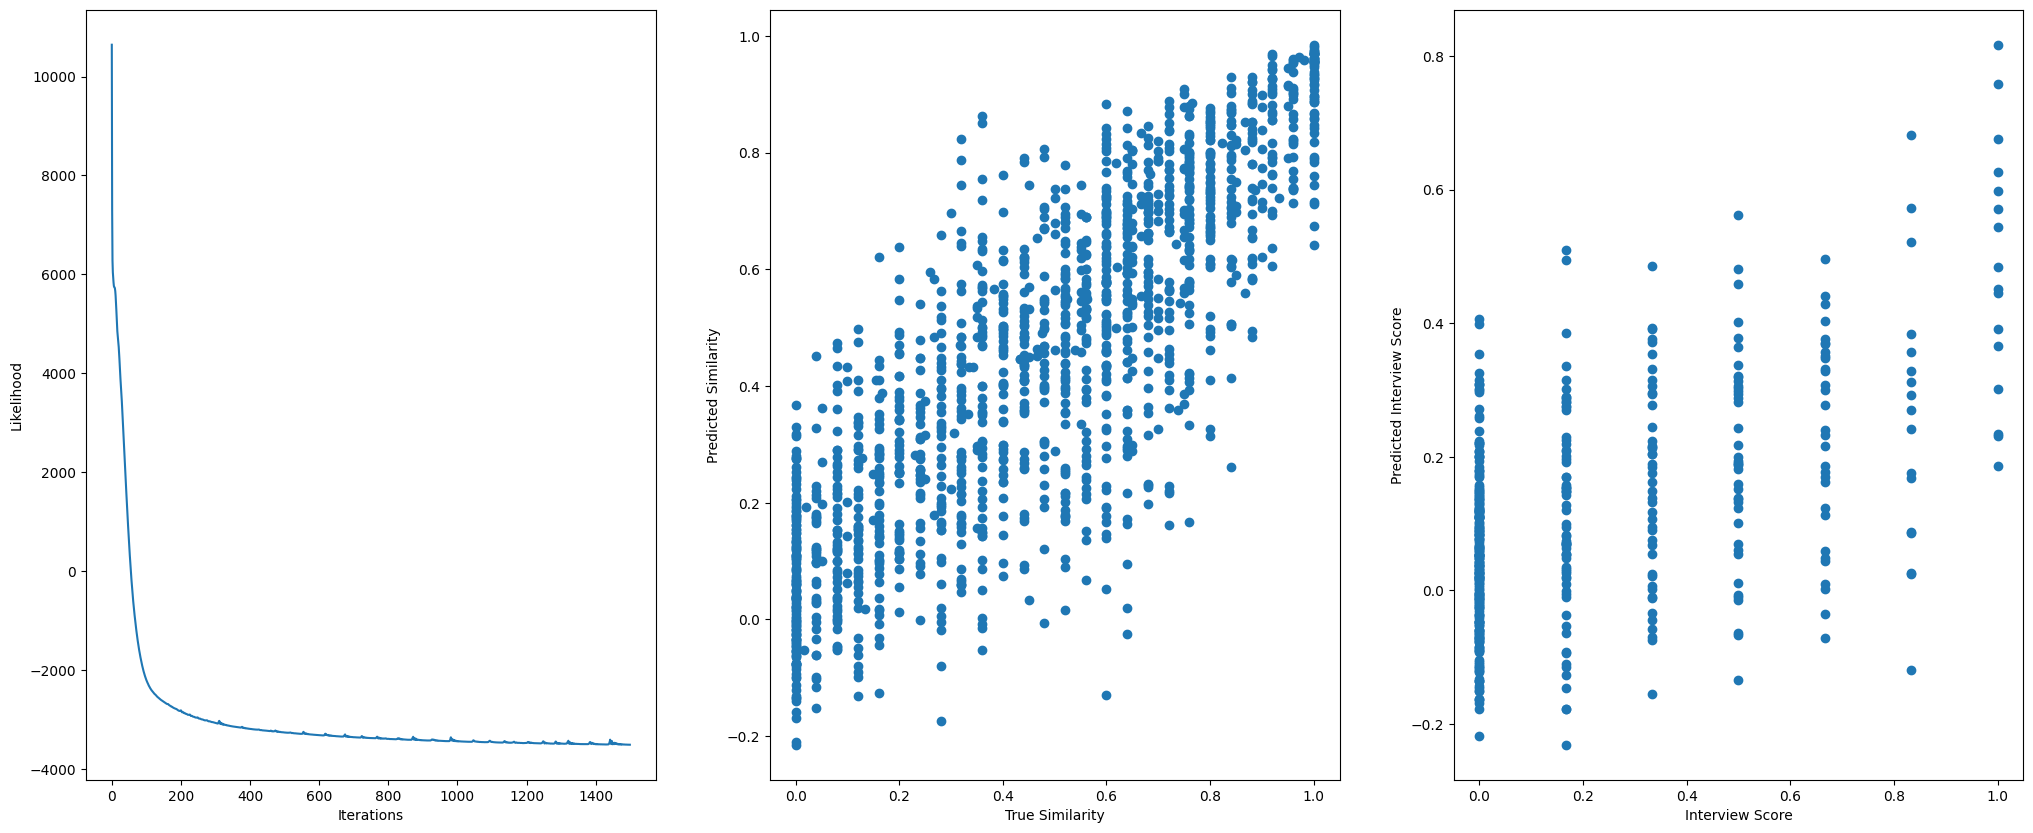

In [7]:
# try abs(embedding1 - embedding2)
# combine train and test in the sts dataset into one and use dev for tuning
# this is because we want to evaluate on how intervew embeddings
pair_combine = 'l1'
X_train = torch.tensor(np.concatenate([embeddings['train'][pair_combine], embeddings['test'][pair_combine]]))
X_dev = torch.tensor(embeddings['dev'][pair_combine])
Y_train = torch.tensor(np.concatenate([data['train']['score'], data['test']['score']]))
Y_dev = torch.tensor(data['dev']['score'])

interview_test = torch.tensor(interview_embeddings[pair_combine])

# sparse points for sparse regression
sparse_points = 20
Xu = (X_train.clone())[np.random.choice(X_train.shape[0], sparse_points)]

kernel = gp.kernels.RBF(input_dim=X_train.shape[1])
likelihood = gp.likelihoods.Gaussian()
vsgp = gp.models.VariationalSparseGP(torch.tensor(X_train), torch.tensor(Y_train), Xu=Xu, kernel = kernel,
                                    likelihood = likelihood, whiten=True)
losses = gp.util.train(vsgp, num_steps = 1500)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25, 10))
ax1.plot(losses)
ax1.set_ylabel('Likelihood')
ax1.set_xlabel('Iterations')

Y_pred = vsgp(X_dev)[0]
ax2.scatter(Y_dev.detach(), Y_pred.detach())
ax2.set_xlabel('True Similarity')
ax2.set_ylabel('Predicted Similarity')
print('Pearson, STS dev', pearsonr(Y_dev.detach(), Y_pred.detach()))

interview_scores_pred = vsgp(interview_test)[0]
ax3.scatter(interview_scores, interview_scores_pred.detach())
ax3.set_xlabel('Interview Score')
ax3.set_ylabel('Predicted Interview Score')
print('Pearson, interview scores', pearsonr(interview_scores, interview_scores_pred.detach()))

/tmp/ipykernel_59807/2464175514.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vsgp = gp.models.VariationalSparseGP(torch.tensor(X_train), torch.tensor(Y_train), Xu=Xu, kernel = kernel,


Pearson, STS dev PearsonRResult(statistic=0.8402200054047099, pvalue=0.0)
Pearson, interview scores PearsonRResult(statistic=0.6107739778989322, pvalue=2.9607640258017735e-47)


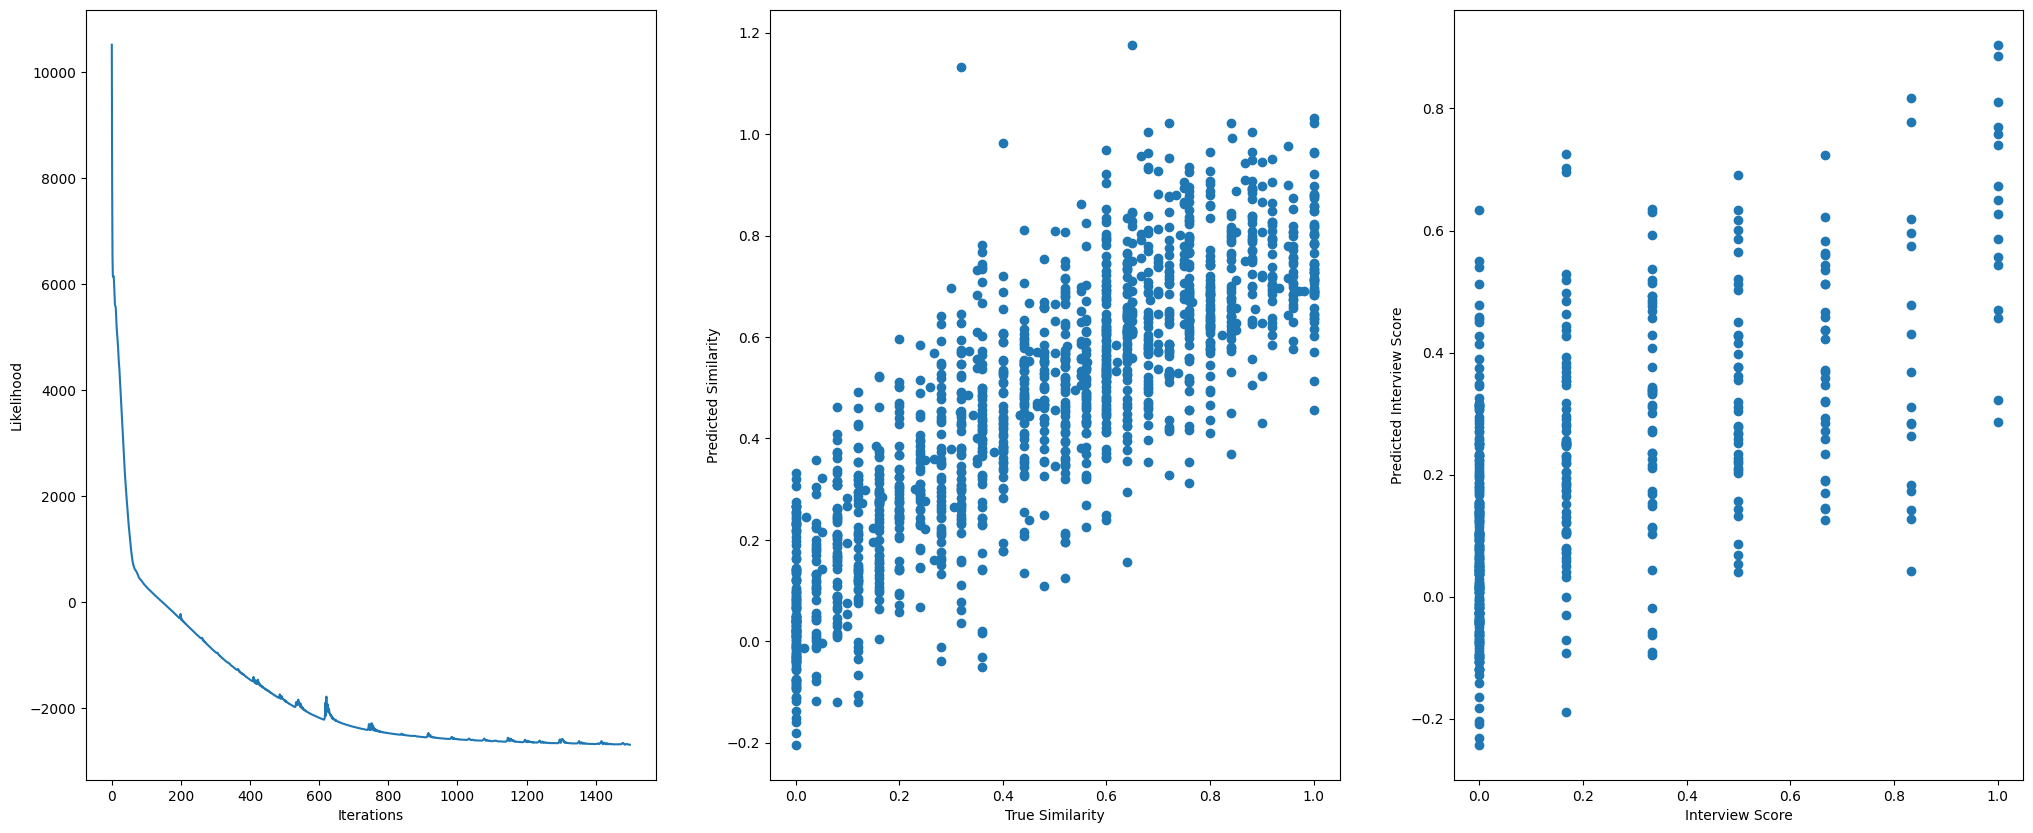

In [8]:
# try embedding1 * embedding2
# combine train and test in the sts dataset into one and use dev for tuning
# this is because we want to evaluate on how intervew embeddings
pair_combine = 'prod'
X_train = torch.tensor(np.concatenate([embeddings['train'][pair_combine], embeddings['test'][pair_combine]]))
X_dev = torch.tensor(embeddings['dev'][pair_combine])
Y_train = torch.tensor(np.concatenate([data['train']['score'], data['test']['score']]))
Y_dev = torch.tensor(data['dev']['score'])

interview_test = torch.tensor(interview_embeddings[pair_combine])

# sparse points for sparse regression
sparse_points = 20
Xu = (X_train.clone())[np.random.choice(X_train.shape[0], sparse_points)]

kernel = gp.kernels.RBF(input_dim=X_train.shape[1])
likelihood = gp.likelihoods.Gaussian()
vsgp = gp.models.VariationalSparseGP(torch.tensor(X_train), torch.tensor(Y_train), Xu=Xu, kernel = kernel,
                                    likelihood = likelihood, whiten=True)
losses = gp.util.train(vsgp, num_steps = 1500)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25, 10))
ax1.plot(losses)
ax1.set_ylabel('Likelihood')
ax1.set_xlabel('Iterations')

Y_pred = vsgp(X_dev)[0]
ax2.scatter(Y_dev.detach(), Y_pred.detach())
ax2.set_xlabel('True Similarity')
ax2.set_ylabel('Predicted Similarity')
print('Pearson, STS dev', pearsonr(Y_dev.detach(), Y_pred.detach()))

interview_scores_pred = vsgp(interview_test)[0]
ax3.scatter(interview_scores, interview_scores_pred.detach())
ax3.set_xlabel('Interview Score')
ax3.set_ylabel('Predicted Interview Score')
print('Pearson, interview scores', pearsonr(interview_scores, interview_scores_pred.detach()))

/tmp/ipykernel_59807/1611789167.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vsgp = gp.models.VariationalSparseGP(torch.tensor(X_train), torch.tensor(Y_train), Xu=Xu, kernel = kernel,


Pearson, STS dev PearsonRResult(statistic=0.30619152761649754, pvalue=6.3527684595338366e-34)
Pearson, interview scores PearsonRResult(statistic=-0.007206987591580769, pvalue=0.8789585171001426)


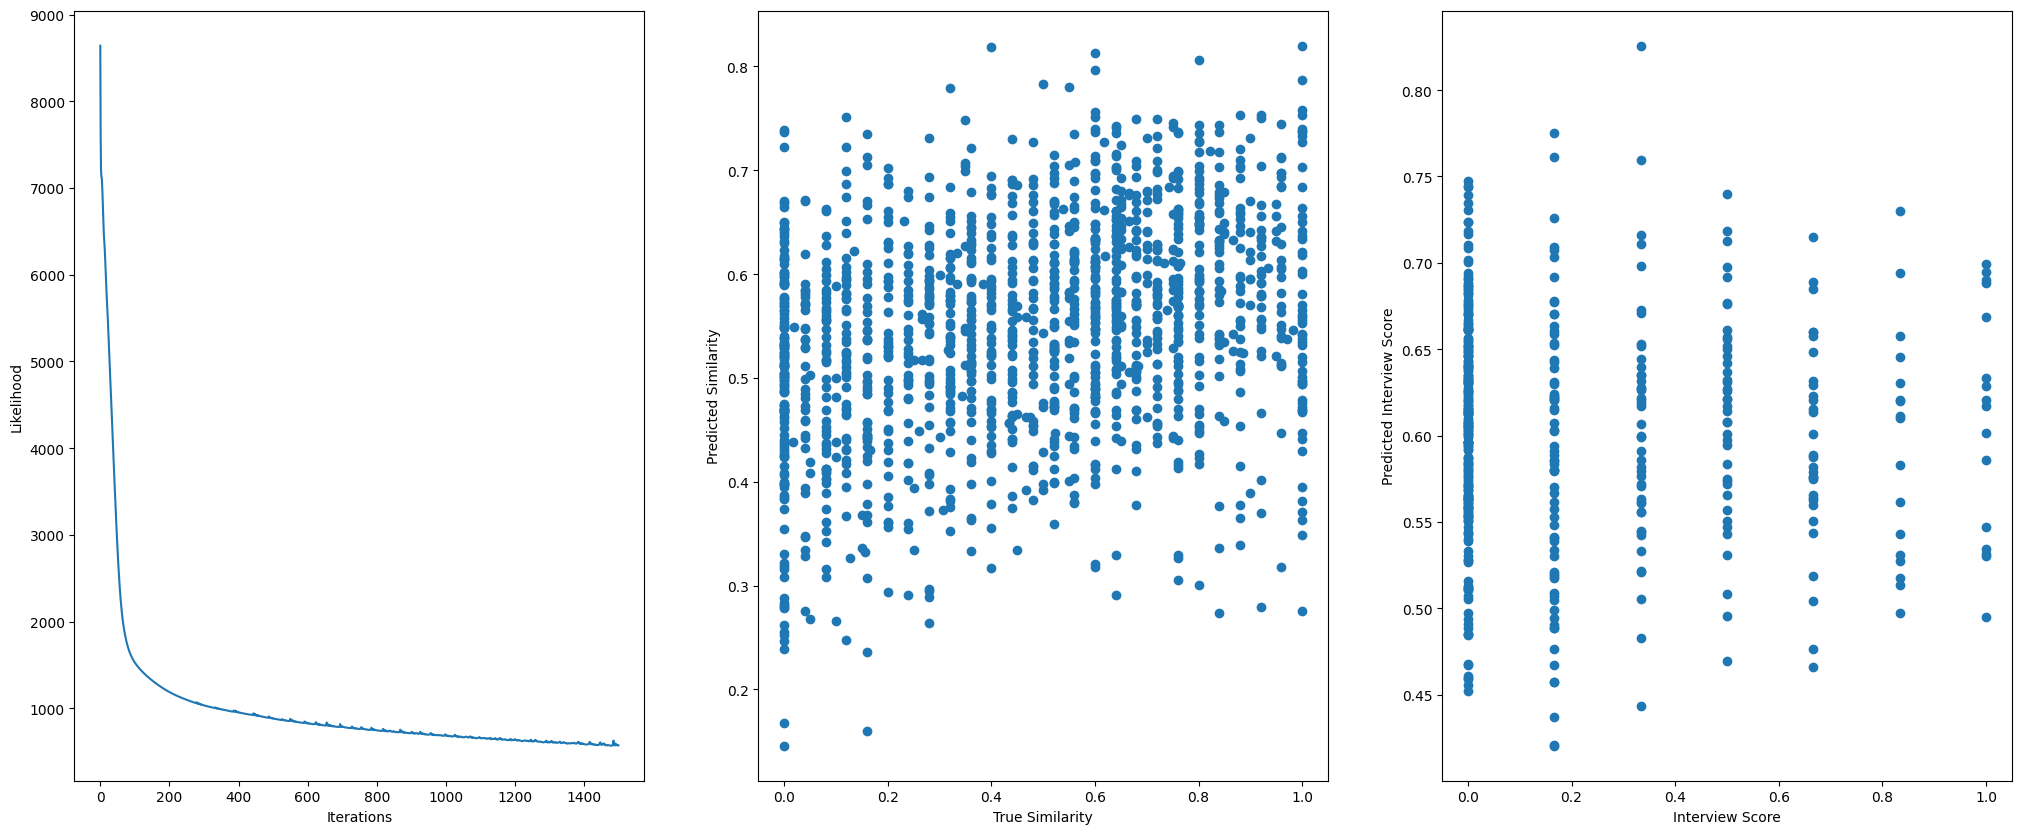

In [9]:
# try embedding1 (+) embedding2
# combine train and test in the sts dataset into one and use dev for tuning
# this is because we want to evaluate on how intervew embeddings
pair_combine = 'dsum'
X_train = torch.tensor(np.concatenate([embeddings['train'][pair_combine], embeddings['test'][pair_combine]]))
X_dev = torch.tensor(embeddings['dev'][pair_combine])
Y_train = torch.tensor(np.concatenate([data['train']['score'], data['test']['score']]))
Y_dev = torch.tensor(data['dev']['score'])

interview_test = torch.tensor(interview_embeddings[pair_combine])

# sparse points for sparse regression
sparse_points = 20
Xu = (X_train.clone())[np.random.choice(X_train.shape[0], sparse_points)]

kernel = gp.kernels.RBF(input_dim=X_train.shape[1])
likelihood = gp.likelihoods.Gaussian()
vsgp = gp.models.VariationalSparseGP(torch.tensor(X_train), torch.tensor(Y_train), Xu=Xu, kernel = kernel,
                                    likelihood = likelihood, whiten=True)
losses = gp.util.train(vsgp, num_steps = 1500)
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(25, 10))
ax1.plot(losses)
ax1.set_ylabel('Likelihood')
ax1.set_xlabel('Iterations')

Y_pred = vsgp(X_dev)[0]
ax2.scatter(Y_dev.detach(), Y_pred.detach())
ax2.set_xlabel('True Similarity')
ax2.set_ylabel('Predicted Similarity')
print('Pearson, STS dev', pearsonr(Y_dev.detach(), Y_pred.detach()))

interview_scores_pred = vsgp(interview_test)[0]
ax3.scatter(interview_scores, interview_scores_pred.detach())
ax3.set_xlabel('Interview Score')
ax3.set_ylabel('Predicted Interview Score')
print('Pearson, interview scores', pearsonr(interview_scores, interview_scores_pred.detach()))

In [14]:
for i in vsgp.parameters():
    print(i)

Parameter containing:
tensor([[-0.1936,  0.0656, -0.5273,  ...,  0.9483, -0.1192,  0.2901],
        [ 0.0915, -0.4455, -0.3524,  ...,  0.4221, -0.0140, -0.0625],
        [-0.0059,  0.1564,  0.0506,  ..., -0.0228, -0.0841,  0.0345],
        ...,
        [ 0.0182,  0.1516,  0.0389,  ...,  0.0979,  0.0195,  0.0472],
        [ 0.0432,  0.0806,  0.0422,  ...,  0.0559, -0.0480,  0.0045],
        [ 0.1114,  0.0997, -0.0088,  ..., -0.0453, -0.1078,  0.0387]],
       requires_grad=True)
Parameter containing:
tensor([0.9275, 1.1657, 1.1727, 1.6300, 1.8355, 1.6587, 1.7469, 2.2711, 1.8738,
        1.4685, 2.3429, 1.5340, 2.6775, 3.0610, 3.6358, 5.8349, 6.1351, 5.5449,
        6.7415, 2.9067], requires_grad=True)
Parameter containing:
tensor([[-6.0164e-02,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          0.0000e+00,  0.0000e+00,  0.0000e+00

In [16]:
from pyro.params.param_store import ParamStoreDict

In [23]:
params = vsgp.parameters()

In [24]:
type(params)

generator

In [25]:
type(vsgp)

pyro.contrib.gp.models.vsgp.VariationalSparseGP

In [27]:
torch.save(vsgp, 'aa.save')